The code from tutorial week_6.ipynb and week_8.ipynb is used in this notebook, which is really useful for me to finish this coursework and understand the concept of the special network. 
<br>
<br>
Credit to the lecturers and TAs.

In [2]:
import os
import glob
import time
import esda
import random
import geopandas
import spaghetti
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from haversine import haversine
from geopandas import GeoDataFrame
from sklearn.cluster import KMeans
from shapely.geometry import Point, LineString

/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


# Load the data

In [2]:
ACCIDENTS_DIR = "./data/"
USE_COLS = ['Grid Ref: Easting', 'Grid Ref: Northing']
leeds_df = [pd.read_csv(csv_file, usecols=USE_COLS, encoding="ISO-8859-1") for path, subdir, _  in os.walk(ACCIDENTS_DIR) for csv_file in glob.glob(os.path.join(path, "*.csv"))]
print("Found {} CSV files in {}".format(len(leeds_df), ACCIDENTS_DIR))

leeds_df = pd.concat(leeds_df, axis=0, ignore_index=True)
print("Total no. of accidents loaded: {}".format(len(leeds_df)))

# Drop rows with NaN values
located_accidents = leeds_df.dropna(subset=USE_COLS)
print("Total no. of located accidents filtered: {}".format(len(located_accidents)))

Found 5 CSV files in ./data/
Total no. of accidents loaded: 11318
Total no. of located accidents filtered: 11318


In [3]:
accident_points = geopandas.GeoDataFrame(
    leeds_df, geometry=geopandas.points_from_xy(leeds_df[USE_COLS[0]], leeds_df[USE_COLS[1]],crs="EPSG:27700")).to_crs("EPSG:4326").drop(USE_COLS, axis=1)
accident_points

,geometry
0,POINT (-1.45256 53.80967)
1,POINT (-1.45256 53.80967)
2,POINT (-1.45256 53.80967)
3,POINT (-1.45256 53.80967)
4,POINT (-1.45256 53.80967)
...,...
11313,POINT (-1.54106 53.77605)
11314,POINT (-1.57996 53.82357)
11315,POINT (-1.69290 53.80443)
11316,POINT (-1.51624 53.81813)


# Task A

In [4]:
PLACE_OF_INTEREST = "Leeds, United Kingdom"
leeds = ox.geocode_to_gdf(PLACE_OF_INTEREST)

In [5]:
leeds_polygon = ox.project_gdf(leeds)

# The area of the city of Leeds is 551.7 km2
area_of_leeds = leeds_polygon.area.iloc[0] / 1e6
print("Area of Leeds: {} km2".format(area_of_leeds))

Area of Leeds: 551.7910763342367 km2


In [6]:
# Get the center of the city of Leeds
leeds_center = leeds_polygon.centroid

# buffer around 1 square kilometer area of the center of leeds
leeds_center = leeds_center.buffer(570)

# get the area of the buffer
leeds_center_area = leeds_center.area.iloc[0] / 1e6
print("Area of Leeds buffer: {} km2".format(leeds_center_area))

# Convert buffer back to EPSG:4326
leeds_center = leeds_center.to_crs("EPSG:4326")[0]

# Get the accidents within the buffer
leeds_accident = accident_points[accident_points.geometry.within(leeds_center)]
print("Total no. of accidents within the buffer: {}".format(len(leeds_accident)))

Area of Leeds buffer: 1.019064604578625 km2
Total no. of accidents within the buffer: 51


In [7]:
for x in range(0, -1400, -200):
    for y in range(0, -1400, -200):
        leeds_center = leeds_polygon.centroid
        # Shift the center of the polygon by 100 meters in x and y direction
        leeds_center = leeds_center.translate(x, y)
        # Get the buffer around the shifted center
        leeds_center = leeds_center.buffer(570)

        # Convert buffer back to EPSG:4326
        leeds_center = leeds_center.to_crs("EPSG:4326")[0]

        # Get the accidents within the buffer
        leeds_accident = accident_points[accident_points.geometry.within(leeds_center)]
        if len(leeds_accident) >= 300:
            print("Shifted center: {}, {}".format(x, y))
            print("Total no. of accidents within the buffer: {}".format(len(leeds_accident)))

Shifted center: -800, -1200
Total no. of accidents within the buffer: 323
Shifted center: -1000, -1200
Total no. of accidents within the buffer: 332
Shifted center: -1200, -1200
Total no. of accidents within the buffer: 300


In [8]:
# Get the center of the polygon
leeds_center_point = leeds_polygon.centroid

# Shift the center of the polygon by -800 meters in x direction, and -1200 meters in y direction
x_shfit = -800
y_shift = -1200

leeds_center_shifted = leeds_center_point.translate(x_shfit, y_shift)
leeds_center_shifted = leeds_center_shifted.buffer(570)

# Convert buffer back to EPSG:4326
leeds_center_shifted = leeds_center_shifted.to_crs("EPSG:4326")[0]

# Get the accidents within the buffer
leeds_accident = accident_points[accident_points.geometry.within(leeds_center_shifted)]
print("Total no. of accidents within the buffer: {}".format(len(leeds_accident)))

Total no. of accidents within the buffer: 323


In [9]:
# Get the location of the points
leeds_center_location = leeds_polygon.centroid.to_crs("EPSG:4326")
leeds_center_shifted_location = leeds_center_point.translate(-800, -1200).to_crs("EPSG:4326")
print("The center of Leeds is: longitude {} and latitude {}".format(leeds_center_location.x.iloc[0], leeds_center_location.y.iloc[0]))
print("The shifted center of Leeds is: longtitute {} and latitude {}".format(leeds_center_shifted_location.x.iloc[0], leeds_center_shifted_location.y.iloc[0]))

The center of Leeds is: longitude -1.5060131804825265 and latitude 53.82574632975675
The shifted center of Leeds is: longtitute -1.5185433520450609 and latitude 53.81511483094514


/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


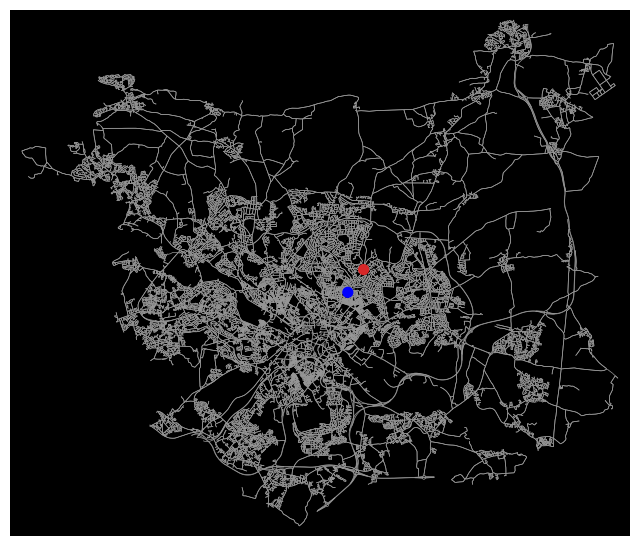

In [10]:
drive_network = ox.graph_from_place(PLACE_OF_INTEREST, network_type='drive')
fig, ax = ox.plot_graph(drive_network, node_size=0, edge_linewidth=0.5, edge_alpha=1, bgcolor='k', show=False)

lats = [leeds_center_location.y.iloc[0], leeds_center_shifted_location.y.iloc[0]]
lons = [leeds_center_location.x.iloc[0], leeds_center_shifted_location.x.iloc[0]]

ax.scatter(lons, lats, c=['tab:red', 'blue'], s=50)

1. What are the characteristics of this road network? Include, at least, the spatial diameter of the network, the average street length, node density, intersection density, and edge density.
2. What is the average circuitry of the network? What does this tell you about the efficiency of using roads in this area?

In [11]:
# change the leeds_center_shifted to geodataframe
leeds_center_shifted_gdf = geopandas.GeoDataFrame(geometry=[leeds_center_shifted]).set_crs("EPSG:4326")
leeds_area = ox.project_gdf(leeds_center_shifted_gdf).unary_union.area

In [12]:
leeds_center_graph = ox.graph_from_polygon(leeds_center_shifted, network_type = 'drive')
spatial_diameter = max([max(shortest_path.values()) for shortest_path in list(dict(nx.all_pairs_dijkstra_path_length(leeds_center_graph, weight="length")).values())])
spatial_diameter

/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


1893.1369999999995

In [13]:
basic_stats = ox.basic_stats(leeds_center_graph, area=leeds_area)
basic_stats
# print("The spatial diameter: {}".format(str(spatial_diameter)))
# print("The average street length: {}".format(str(basic_stats['street_length_avg'])))
# print("The node density: {}".format(str(basic_stats['node_density_km'])))
# print("The intersection density: {}".format(str(basic_stats['intersection_density_km'])))
# print("The edge density: {}".format(str(basic_stats['edge_density_km'])))

{'n': 339,
 'm': 881,
 'k_avg': 5.1976401179941005,
 'edge_length_total': 49914.37399999998,
 'edge_length_avg': 56.65649716231553,
 'streets_per_node_avg': 2.8731563421828907,
 'streets_per_node_counts': {0: 0, 1: 44, 2: 5, 3: 241, 4: 48, 5: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.12979351032448377,
  2: 0.014749262536873156,
  3: 0.7109144542772862,
  4: 0.1415929203539823,
  5: 0.0029498525073746312},
 'intersection_count': 295,
 'street_length_total': 26125.403000000013,
 'street_segment_count': 464,
 'street_length_avg': 56.30474784482762,
 'circuity_avg': 1.023291320272164,
 'self_loop_proportion': 0.0,
 'node_density_km': 332.65800664345824,
 'intersection_density_km': 289.48115622365833,
 'edge_density_km': 48980.57863627154,
 'street_density_km': 25636.65039745436}

## 3. Is the network planar? Why/why not?

In [14]:
is_planar, planar_embedding = nx.check_planarity(leeds_center_graph, counterexample=True)
is_planar

True

In [15]:
type(planar_embedding)

networkx.algorithms.planarity.PlanarEmbedding

In [16]:
try:
    list(nx.eulerian_circuit(planar_embedding))
except nx.NetworkXError as e:
    print(e)

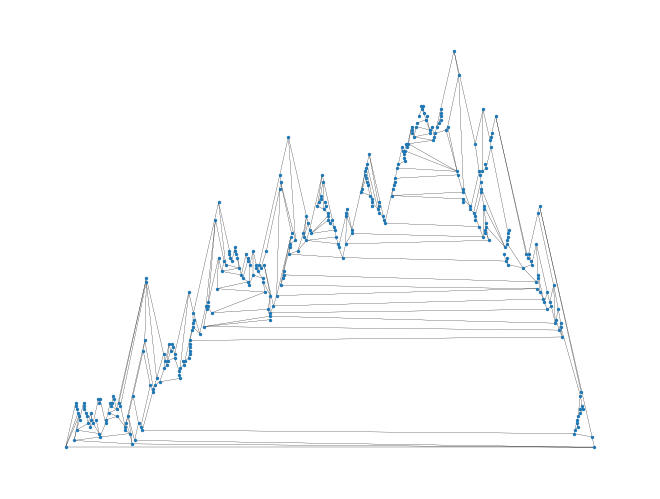

In [17]:
# use kawayi layout to draw the graph
# use planar layout to draw the graph and make it look nicer
nx.draw(planar_embedding, pos = nx.planar_layout(planar_embedding), node_size=2, with_labels=False, node_color='tab:blue', edge_color='k', width=0.1)

# Task B

1. Plot the distribution of road accidents on your road network and visualise this. 

In [18]:
# Some edges are missing a geometry, so we will create one
# assuming that the road is a direct line from start point to end point.
# First, we need to get the locations of the points
x_values = nx.get_node_attributes(leeds_center_graph, 'x')
y_values = nx.get_node_attributes(leeds_center_graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(leeds_center_graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

In [19]:
len(graph_with_geometries) # 881 streets

881

In [20]:
# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe.head()

,osmid,oneway,lanes,highway,reversed,length,geometry,name,ref,maxspeed
0,654665558,True,2,tertiary,False,18.603,"LINESTRING (-1.51502 53.81857, -1.51501 53.81840)",NaN,NaN,NaN
1,654665559,False,NaN,tertiary,True,56.457,"LINESTRING (-1.51502 53.81857, -1.51455 53.81899)",Roundhay Road,NaN,NaN
2,5098649,True,2,trunk,False,39.678,"LINESTRING (-1.51627 53.81747, -1.51609 53.817...",NaN,A58,30 mph
3,"[544653036, 39002261]",False,4,trunk,True,67.302,"LINESTRING (-1.51627 53.81747, -1.51652 53.817...",Roundhay Road,A58,30 mph
4,39002261,False,4,trunk,False,28.983,"LINESTRING (-1.51718 53.81668, -1.51712 53.816...",Roundhay Road,A58,30 mph


In [21]:
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

In [22]:
# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_points_graph, vertices=True, arcs=True)


In [23]:
# We will now snap the center of Leeds located accidents we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(leeds_accident, 'accidents')

# We can see the difference between the original accident coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

observation 1
true coords:	(-1.5237781826423134, 53.81775654909816)
snapped coords:	(-1.523768191200663, 53.817747497555224)


/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/libpysal/cg/shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/libpysal/cg/shapes.py:1006: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


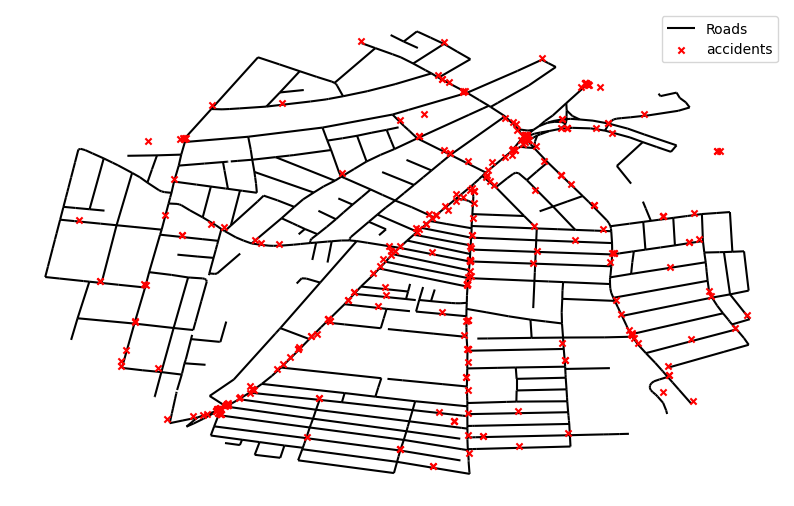

In [24]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(10, 10))
# Get a GeoDataFrame of the snapped accidents locations to plot on the network image
observed_accidents=spaghetti.element_as_gdf(leeds_points_graph, pp_name='accidents', snapped=False)

# Plot these on the road network

observed_accidents.plot(
    color="r", marker="x",
    markersize=20, zorder=1, ax=base_network)

# Turn off the axis
base_network.axis("off")

# Show the legend
base_network.legend(["Roads", "accidents"])

plt.show()

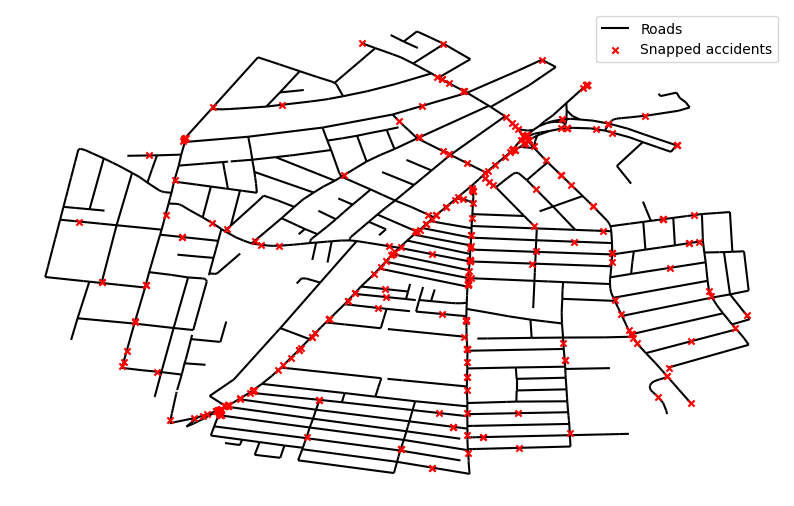

In [25]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(10, 10))
# Get a GeoDataFrame of the snapped accidents locations to plot on the network image
snapped_accidents=spaghetti.element_as_gdf(leeds_points_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=20, zorder=1, ax=base_network)

base_network.axis("off")

# Show the legend
base_network.legend(["Roads", "Snapped accidents"])


plt.show()

2. Investigate whether a high number of accidents on one road correlates with a high number on connecting roads.

Now we will perform this week's analysis, first using the K-function analysis provided by `spaghetti`. For each point, the density of other points within a series of bands at increasing steps of distance is calculated, where the number of bands is given by variable **nsteps**. This is then averaged across points to get the K value. Alongside this, it is simulated what density would be seen under instances of complete spatial randomness of distribution of points on the network (a Monte Carlo simulation). As each instance of a random placing of points will be different, it runs this simulation a number of times, given by parameter **permutations**. Looking at the range of values produced by the simulations gives us an approximation of the lower and upper bounds of density expected with a random distribution: if the real values don't fall in these bounds, we may conclude they are not random (either more clustered or more uniform than expected).

In [26]:
kres = leeds_points_graph.GlobalAutoK(
    leeds_points_graph.pointpatterns["accidents"],
    nsteps=50, permutations=100
)

The result of the analysis is held in an object, `kres`, with multiple attributes. The important ones are listed below. Attribute `lam` is the density of points on the network as a whole (the lambda value). This should be a high number for our points, which sounds very dense but remember that our coordinates are longitude/latitude degrees: if we had converted our reference system to metres, it would be a much lower density value. The `axis` attribute is the list of distances at which density is measured, i.e. the bands. The remaining attributes listed all return a list of K-function values, one for each distance band: `observed` is for our real data, `upperenvelope` and `lowerenvelope` give the maximum and minimum values found in the simulation, while `sim` is the data from all the simulations: a list of lists of K-function values.

In [27]:
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

Density of points in the network (lambda): 977.68758886029


In [28]:
print(f"Distances at which density is measured:\n{kres.xaxis}")

Distances at which density is measured:
[0.         0.0004331  0.00086619 0.00129929 0.00173239 0.00216548
 0.00259858 0.00303168 0.00346477 0.00389787 0.00433097 0.00476406
 0.00519716 0.00563026 0.00606335 0.00649645 0.00692955 0.00736264
 0.00779574 0.00822884 0.00866193 0.00909503 0.00952813 0.00996122
 0.01039432 0.01082742 0.01126051 0.01169361 0.01212671 0.0125598
 0.0129929  0.013426   0.01385909 0.01429219 0.01472529 0.01515838
 0.01559148 0.01602458 0.01645768 0.01689077 0.01732387 0.01775697
 0.01819006 0.01862316 0.01905626 0.01948935 0.01992245 0.02035555
 0.02078864 0.02122174]


We can now plot the above data so that we can judge it visually. The code below will create a plot with three lines: the observed K-function values as the band distance increases, and the upper and lower bounds from the simulations.

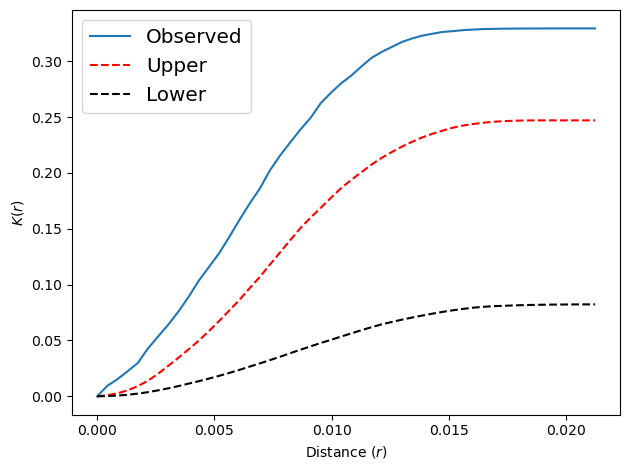

In [29]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "tab:blue", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

The above seems to show that, at all distances and increasing as distance increases, the points are more clustered than would be expected.

However, we need to be aware that the accident data is not showing the precise locations of crimes but just what street each crime occurred on. Because of this, it is perhaps more meaningful to look at crime counts per street. We will then ask whether these counts are spatially autocorrelated on the network space. To do this, we first get the pattern of crime points snapped to the network, and then get the count of points per each street (network edge).

In [30]:
# Get snapped point pattern 
pointpat = leeds_points_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the accident count on that edge
counts = leeds_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)

Next, we need our spatial weights. As discussed in lesson, this is the edge adjacency matrix, i.e. a matrix where the edges are the rows and columns and there is a 1 wherever the edges are connected by a node, 0 otherwise.

In [31]:
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_points_graph.w_network

As a final preparation step for running the analysis, we need to put the edge counts in a list in the same order as the weights. This is just required for the autocorrelation calculation function we will use.

In [32]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

Now we can calculate Moran's I using the crime count values and weights we've prepared.

In [33]:
moran = esda.moran.Moran(values, weights)
moran.I

0.08626970118596863

Our value for the statistic needs to be interpreted against a reference distribution under the null of CSR. PySAL uses a similar approach as we saw in the join count analysis: random spatial permutations.

In [34]:
moran.p_sim

0.005

This should return a value close to zero, possibly implying no detectable autocorrelation. If you check the weights list after running the above method, you will notice that the **weights** have been row normalised: this is a step in the process of calculating Moran's I. We can check the significance of this compared to the simulation by looking at `moran.p_sim`, the p-value compared to the simulated case. This gives a value > 0.005, meaning we have not proven the case for autocorrelation between accident values, although we observe a mild tendency towards dispersion (as `moran.I` is a small negative value and 0.005 < `moran.psim` < 0.05).

We can get other relevant values as attributes of the **moran** result object, such as those below. `EI` is the expected value of Moran's I given the number of points plotted, i.e. the value of Moran's I that would be most indicative of complete randomness, which is -1/n-1. `EI_sim` gives the average Moran's I value from the simulations.

In [35]:
moran.EI

-0.001256281407035176

In [36]:
moran.EI_sim

-0.0033278444037329533

In [37]:
moran.z_norm

2.9814961905769892

In [38]:
moran.z_sim

3.3082489655569236

Text(0.5, 0, "Moran's I")

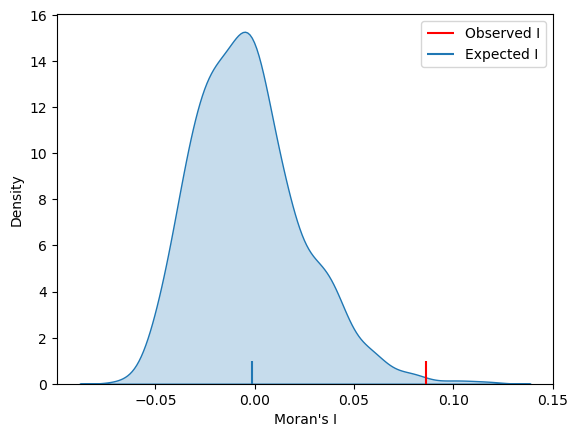

In [39]:
sns.kdeplot(moran.sim, fill=True)
plt.vlines(moran.I, 0, 1, color='r', label='Observed I')
plt.vlines(moran.EI, 0,1, label='Expected I')
plt.legend()
plt.xlabel("Moran's I")

/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/splot/_viz_esda_mpl.py:129: UserWarning: `p` is only used for plotting `esda.moran.Moran_Local`
or `Moran_Local_BV` objects
  warnings.warn('`p` is only used for plotting `esda.moran.Moran_Local`\n'


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Scatterplot (0.09)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

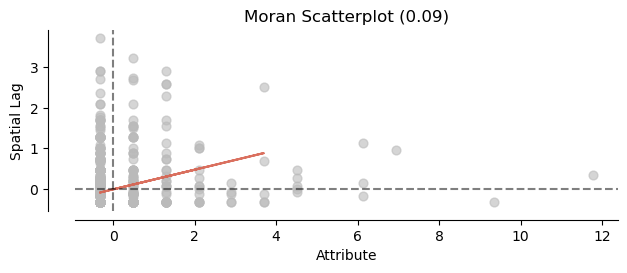

In [41]:
from splot.esda import moran_scatterplot

moran_scatterplot(moran, p=0.05)


In [43]:
moran.z_sim

3.3082489655569236

The full attributes available, including z scores, are listed at https://pysal.org/esda/generated/esda.Moran.html

Taking our K-function analysis and spatial autocorrelation analysis together, it suggests that crimes in Soho were independent of each other (so no significant autocorrelation) but that the external environment has an influence on crime, e.g. buildings on the street network, causing them to be clustered (so high K-function values).

3. Investigate whether accidents happen nearer to intersections or partway along roads. Consider this as asking at what fraction of the road length away from the nearest intersection do accidents typically
occur.

In [153]:
X = snapped_accidents.geometry.x
Y = snapped_accidents.geometry.y
# get which street is the closest to each accident point.
nearest_edges = ox.distance.nearest_edges(leeds_center_graph, X, Y, interpolate=None, return_dist=False)

In [183]:
distence = []
fraction = []
for i in range(len(nearest_edges)):
    street_start = nearest_edges[i][0]
    street_end = nearest_edges[i][1]
    
    # accident point coordinates
    accident_point = (Y[i],X[i]) # lat, lon
    # start and the end of the street where accicents were happened.
    street_start = (leeds_center_graph.nodes()[street_start]['y'],leeds_center_graph.nodes()[street_start]['x'])
    street_end = (leeds_center_graph.nodes()[street_end]['y'],leeds_center_graph.nodes()[street_end]['x'])
    # distance between the accident point and the start and end of the street
    street_length = haversine(street_end,street_start,unit='m')
    accident_to_start = haversine(accident_point,street_start,unit='m')
    accident_to_end = haversine(accident_point,street_end,unit='m')
    
    if accident_to_start>=accident_to_end:
        distence.append(accident_to_end)
        frac = accident_to_end/street_length
        fraction.append(frac)
    else:
        distence.append(accident_to_start)
        frac = accident_to_start/street_length
        fraction.append(frac)

/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_76582/80497326.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraction, hist=True, kde=False,


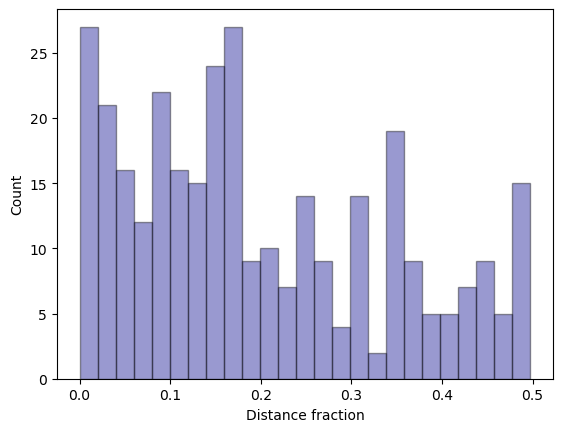

In [186]:
# plot the distribution of the distance fraction between the accident point and the closest street
sns.distplot(fraction, hist=True, kde=False,
                bins=int(25), color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4})
plt.xlabel('Distance fraction')
plt.ylabel('Count')
plt.show()

In [170]:
ave_dist = sum(distence)/len(distence)
road_fraction = round(sum(fraction)/len(fraction), 2) * 100
print('The average distance to the intersection is {} m.'.format(ave_dist)) # m
print('The average fraction of the nearest intersection to accident point is {}%.'.format(road_fraction)) # Proportion

The average distance between accident point to the intersection is 10.342323344574087 m.
The average fraction of the nearest intersection to accident point is 20.0%.


# Task C

In [339]:
PLACE_OF_INTEREST = "Leeds, United Kingdom"
leeds_graph = ox.graph_from_place(PLACE_OF_INTEREST, network_type='drive')

/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [340]:
# Get the coordinates of the nodes in the graph
X = np.array([[node[1]['x'], node[1]['y']] for node in leeds_graph.nodes(data=True)])

# Fit a KMeans model with 10 clusters
kmeans = KMeans(n_clusters=10,n_init = "auto", random_state=0).fit(X)

# Get the cluster centers and get the nearest nodes to the cluster centers as seeds
seeds = ox.nearest_nodes(leeds_graph, kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], return_dist=False)
seeds

[248497499,
 1636581669,
 1955838372,
 1543142533,
 392123154,
 1560077,
 938518749,
 317688615,
 2423171140,
 381915141]

1. Select the initial set of 10 cell seed points. For this, you can use several criteria, such as being far away from frequent accident roads, being close to public transport, being evenly spread, etc. (explain your choice in the report).

In [250]:
# Black color representation
black_color = (0.0, 0.0, 0.0, 1.0)  # change 'k' to RGBs value tuple (0.0, 0.0, 0.0, 1.0) if ValueError

In [370]:
def nodes_nearest_seed(graph, seeds):
    cells = nx.voronoi_cells(graph, seeds, weight='length')
    cells_inverse = {v: key for key, value in cells.items() for v in value}  # inverse cells dict
    return cells, cells_inverse

cells, node_seed_dict = nodes_nearest_seed(leeds_graph, seeds)

In [252]:
def get_seed_color(seeds):
    seed_colors = dict(zip(seeds, ox.plot.get_colors(len(seeds))))  # {seed: seed's mapped color}
    seed_colors['unreachable'] = black_color
    return seed_colors

seed_colors = get_seed_color(seeds)

In [253]:
def map_node_color_from_seed(graph, seeds, node_seed_dict, seed_colors):
    return {node: seed_colors[node_seed_dict[node]] for node in graph.nodes}

node_color_dict = map_node_color_from_seed(leeds_graph, seeds, node_seed_dict, seed_colors)

In [254]:
def map_edge_color_from_node(graph, seeds, node_seed_dict, node_colors, seed_colors):
    edge_colors = []
    for i, e in enumerate(graph.edges):
        color_pair = [node_colors[e[0]], node_colors[e[1]]]
        if black_color in color_pair:  # unreachable
            color_pair.remove(black_color)
            edge_colors.append(color_pair[0])
        elif color_pair[0] == color_pair[1]:
            edge_colors.append(color_pair[0])
        else:
            len_0 = nx.shortest_path_length(graph, node_seed_dict[e[0]], e[0], weight='length')
            len_1 = nx.shortest_path_length(graph, node_seed_dict[e[1]], e[1], weight='length')
            if len_0 <= len_1:  # or discuss on equality cases
                edge_colors.append(color_pair[0])
            else:
                edge_colors.append(color_pair[1])
    return edge_colors

edge_colors = map_edge_color_from_node(leeds_graph, seeds, node_seed_dict, node_color_dict, seed_colors)
node_colors = ['r' if node in seeds else 'None' for node in leeds_graph.nodes]

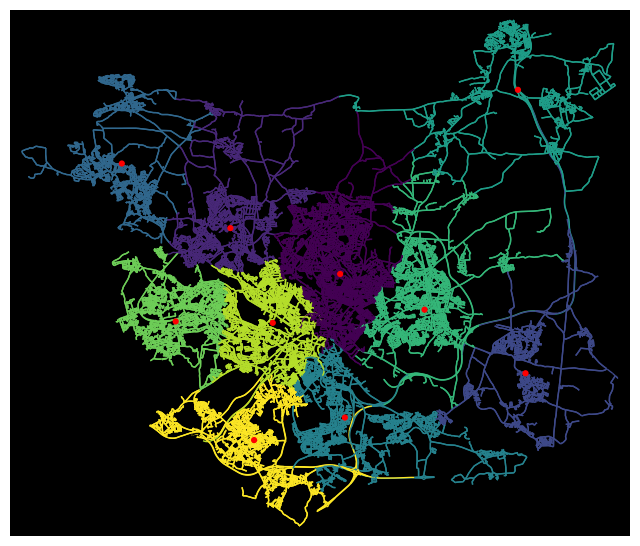

In [72]:
# ox.plot_graph(leeds_graph, edge_color=edge_colors, node_color=node_colors, node_size=20, bgcolor ='k')
# plt.show()

In [371]:
# Remove the unreachable cell
del cells['unreachable']

In [372]:
# Create graphs for each cell
cell_graphs = [leeds_graph.subgraph(cell) for cell in cells.values()]

In [474]:
def find_route(cell_graph):
    cell_graph = nx.Graph(cell_graph)
    basic_cycles = nx.cycle_basis(cell_graph)

    cycles = []
    lengths = []
    for cycle in basic_cycles:
        length = 0
        cycle.append(cycle[0])
        for i in range(len(cycle)-1):
            length += cell_graph.edges[cycle[i], cycle[i+1]]['length']
        cycles.append(cycle)
        lengths.append(length)


    cycle_sorted_by_length = [(cycle, length) for cycle, length in sorted(zip(cycles, lengths), key=lambda pair: pair[1], reverse=True)]

    return cycle_sorted_by_length

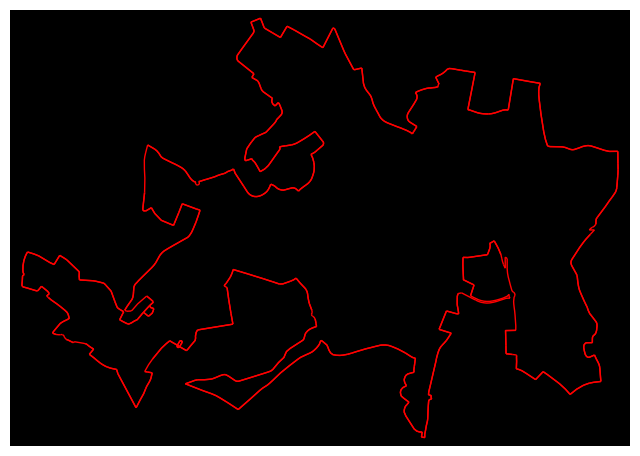

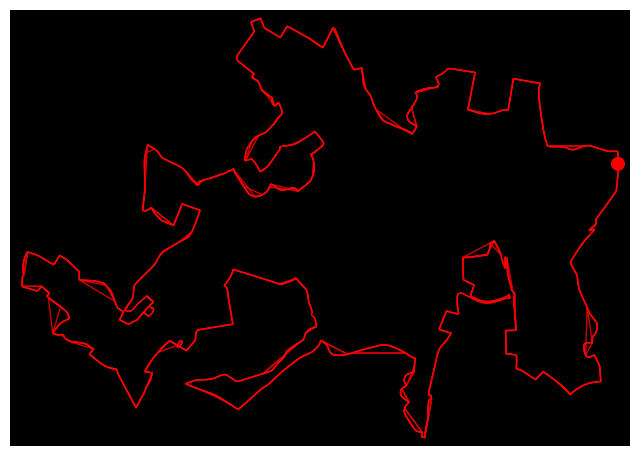

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [476]:
index = 1

route = find_route(cell_graphs[index])
g = cell_graphs[index].subgraph(route[0][0])
ox.plot_graph(g, node_size=0, edge_color='r', bgcolor='k')

fig, ax = ox.plot_graph(g, node_size=0, edge_color='r', bgcolor='k', show=False)
ox.plot_graph_route(cell_graphs[index].to_undirected(), route[0][0], route_linewidth=1, node_size=0, bgcolor='k', route_alpha=0.8, edge_color='k', ax=ax)

In [423]:
def find_route(cell_graph):
    cycles = nx.simple_cycles(cell_graph)
    route = ()
    max_length = 0
    start_time = time.time()
    for cycle in cycles:
        cycle.append(cycle[0])
        length = 0
        for i in range(len(cycle)-1):
            length += cell_graph.get_edge_data(cycle[i], cycle[i+1])[0]["length"]
        
        if length >= 41500 and length <= 42500:
            if length > max_length:
                max_length = length
                route = (cycle, max_length, "orange")

        if length >= 20750 and length <= 21250:
            if length > max_length:
                max_length = length
                route = (cycle, max_length, "tomato")

        if time.time() - start_time > 40:
            print(max_length)
            return route

In [431]:
routes = {}
for i in range(len(cell_graphs)):
    print("cell", i)
    route = find_route(cell_graphs[i])
    if route:
        routes[i] = route

cell 0
0
cell 1
21249.976
cell 2
42456.352999999996
cell 3
0
cell 4
21244.855
cell 5
42434.35799999999
cell 6
0
cell 7
0
cell 8
0
cell 9
0


1


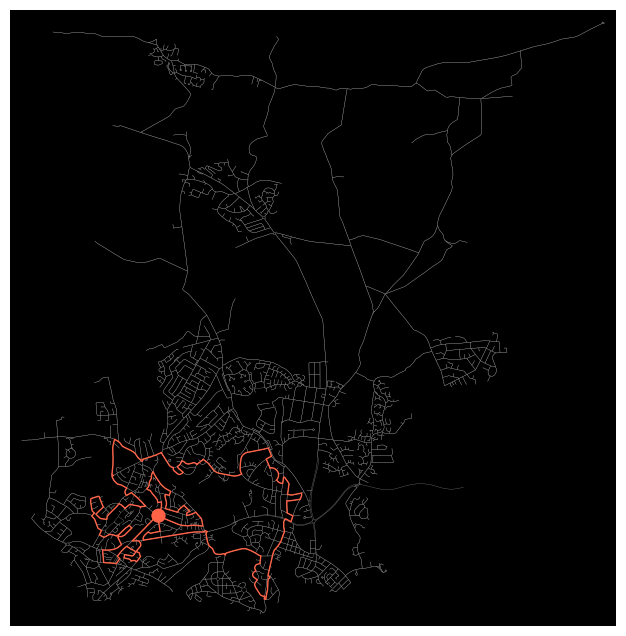

2


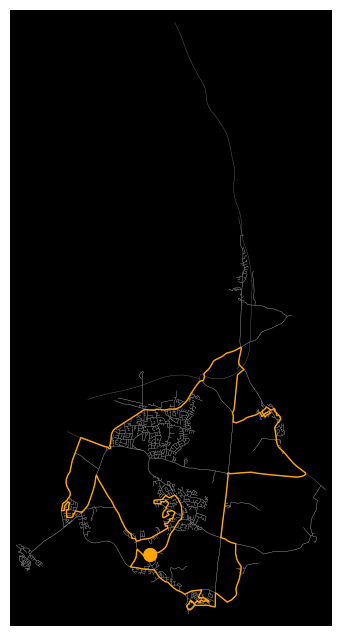

4


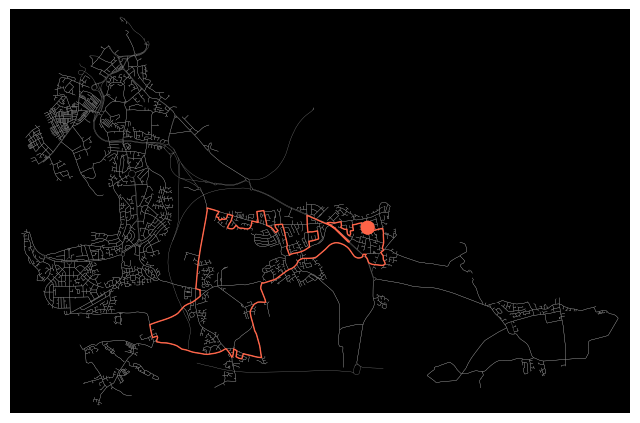

5


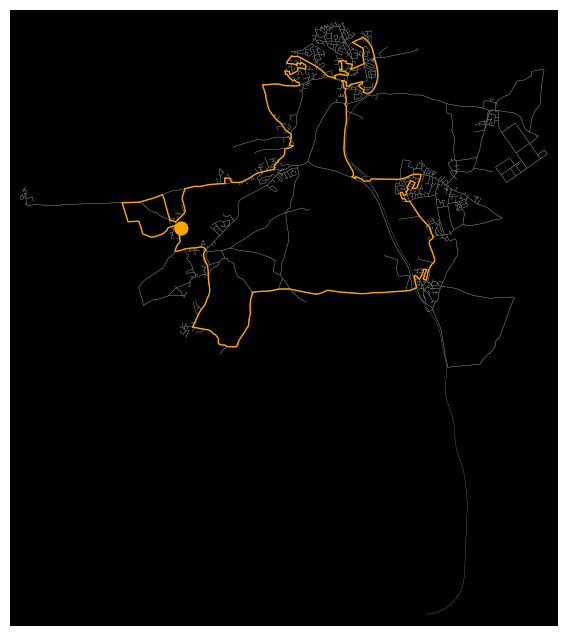

In [497]:
for key in routes.keys():
    print(key)
    fig, ax = ox.plot_graph(cell_graphs[key], node_size=0, bgcolor ='k', show=False, edge_linewidth=0.2)
    ox.plot_graph_route(cell_graphs[key], routes[key][0], route_color=routes[key][2], route_linewidth=1, node_size=0, bgcolor='k', route_alpha=1, ax=ax)

In [432]:
routes.keys()

dict_keys([1, 2, 4, 5])

In [589]:
def find_line_route(cell_graph):
    nodes = list(cell_graph.nodes)

    while True:
        seed = random.choice(nodes)
        # Find the shortest path from the seed to all other nodes
        shortest_paths = nx.single_source_dijkstra_path(cell_graph, seed, weight='length').values()
        shortest_path_lengths = nx.single_source_dijkstra_path_length(cell_graph, seed, weight='length').values()

        # Sort the paths by length
        shortest_path_with_length = [(path, length) for path, length in sorted(zip(shortest_paths, shortest_path_lengths), key=lambda x: x[1], reverse=True)]

        # Get the any two lengths that can add up to between 20750 and 21250  meters
        for i in range(len(shortest_path_with_length)):
            for j in range(len(shortest_path_with_length)):
                total_length = shortest_path_with_length[i][1] + shortest_path_with_length[j][1]
                if total_length <= 21250 and total_length >= 20750:

                    if shortest_path_with_length[i][0] != shortest_path_with_length[j][0]:
                        print(shortest_path_with_length[i][1] + shortest_path_with_length[j][1])
                        return ((shortest_path_with_length[i][0], shortest_path_with_length[j][0]), total_length, "w")

In [456]:
lines = {}
for index, cell_graph in enumerate(cell_graphs):
    print("cell", index)
    line = find_line_route(cell_graph)
    if line:
        lines[index] = line

cell 0
20889.489
cell 1
21239.409000000003
cell 2
21241.556
cell 3
20823.136999999995
cell 4
21190.940999999995
cell 5
21183.97
cell 6
21145.903
cell 7
20785.272999999997
cell 8
21247.138
cell 9
21248.638000000006


21248.39699999999


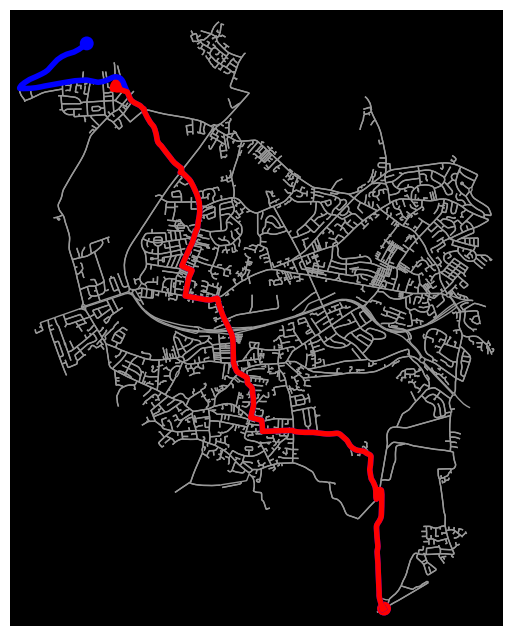

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [670]:
temp_7 = find_line_route(cell_graphs[7])
ox.plot_graph_routes(cell_graphs[7], temp_7[0], route_colors=["b","r"], route_linewidth=1, node_size=0, bgcolor='k', route_alpha=1)

In [671]:
lines[7] = temp_7

0


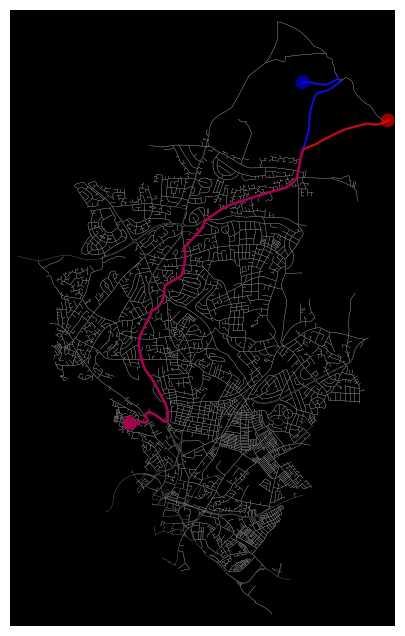

1


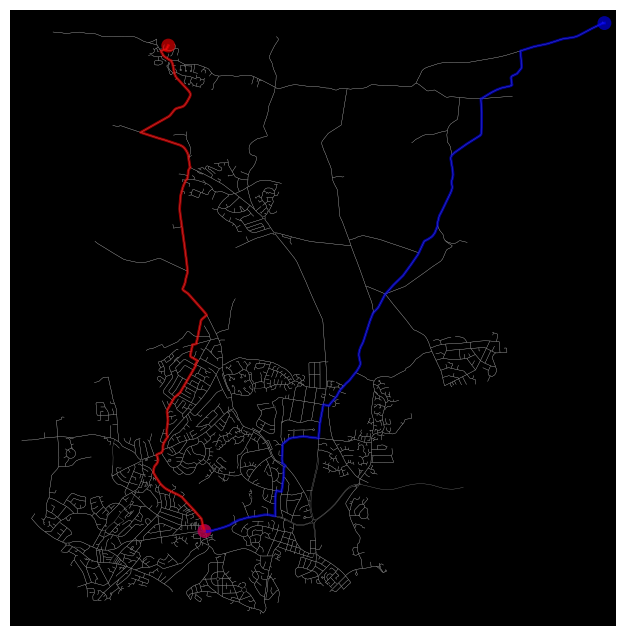

2


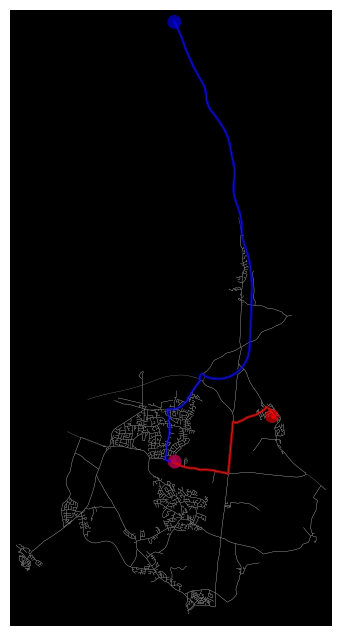

3


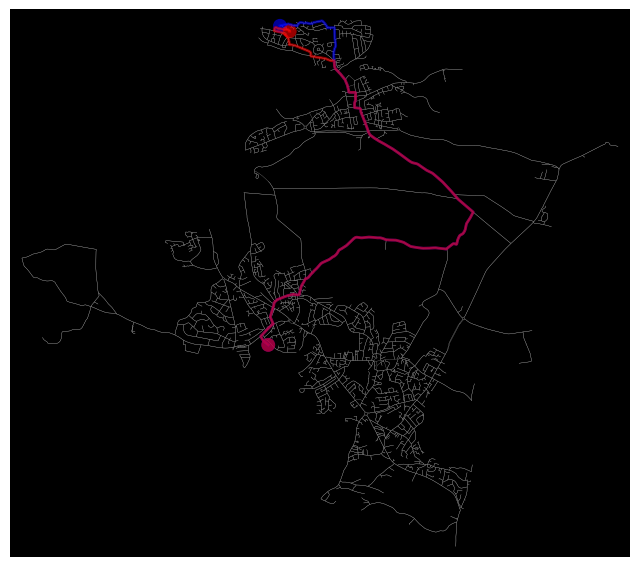

4


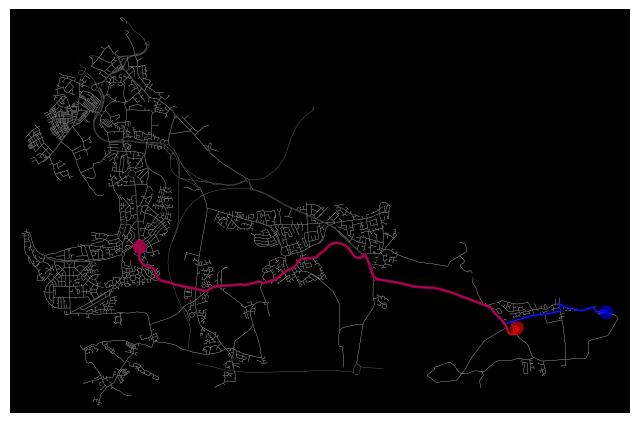

5


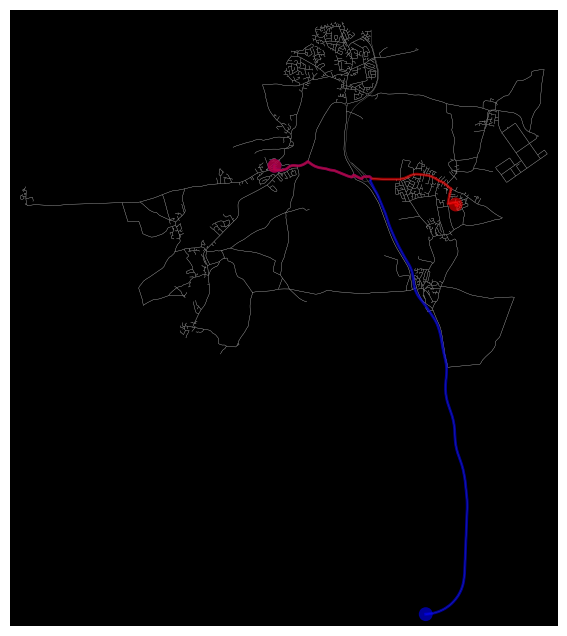

6


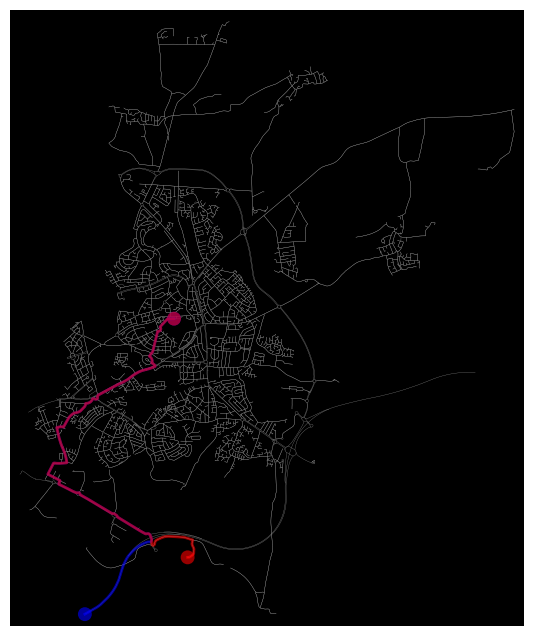

7


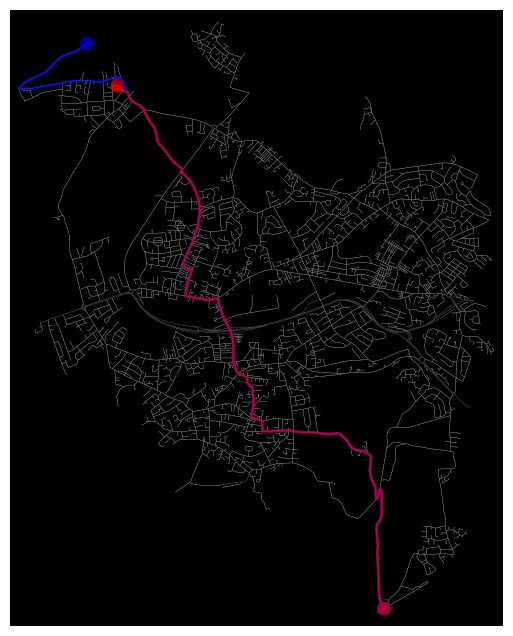

8


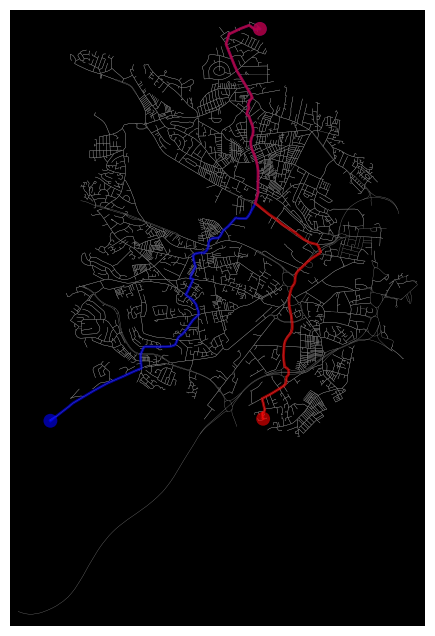

9


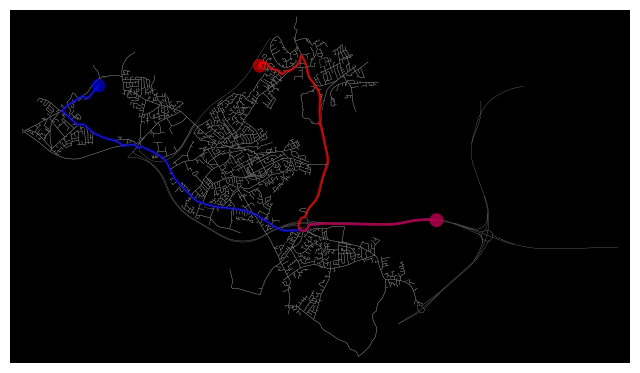

In [672]:
for index, line, cell_graph in zip(range(10), lines.values(), cell_graphs):
    print(index)
    fig, ax = ox.plot_graph(cell_graph, node_size=0, bgcolor ='k', show=False, edge_linewidth=0.2)
    ox.plot_graph_routes(cell_graph, line[0], route_colors=['b','r'], route_linewidths=2, node_size=0, bgcolor='k', route_alpha=0.6, ax=ax)

In [673]:
replace = lines.copy()
for key, value in lines.items():
    if key in routes.keys():
        replace[key] = routes[key]
    else:
        print("Cell", key, "no need to replace")

Cell 0 no need to replace
Cell 3 no need to replace
Cell 6 no need to replace
Cell 7 no need to replace
Cell 8 no need to replace
Cell 9 no need to replace


In [674]:
color = "cyan"

all_routes = []
all_route_colors = []
for value in replace.values():
    if len(value[0]) == 2:
        all_routes.append(value[0][0])
        all_routes.append(value[0][1])
        all_route_colors.append(color)
        all_route_colors.append(color)
    else:
        all_routes.append(value[0])
        all_route_colors.append(value[2])

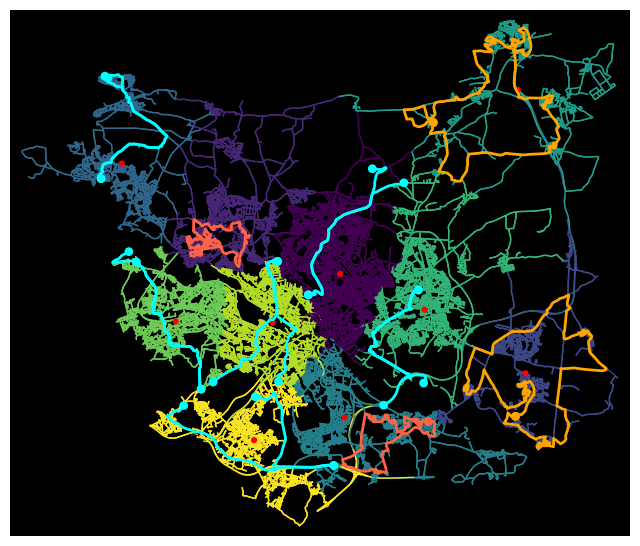

In [675]:
fig, ax = ox.plot_graph(leeds_graph, edge_color=edge_colors, node_color=node_colors, node_size=20, bgcolor ='k', show=False)
ox.plot_graph_routes(leeds_graph, all_routes, route_colors=all_route_colors, route_linewidths=2, node_size=0, bgcolor='k', route_alpha=1, ax=ax, orig_dest_size=40)
plt.show()

In [436]:
def find_42(cell_graph):
    cycles = nx.simple_cycles(cell_graph)
    route = ()
    start_time = time.time()
    for cycle in cycles:
        cycle.append(cycle[0])
        length = 0
        for i in range(len(cycle)-1):
            length += cell_graph.get_edge_data(cycle[i], cycle[i+1])[0]["length"]
        
        # if length >= 41500 and length <= 42500:
        if length >= 41500 and length <= 42000:
            return (cycle, length, "orange")

        if time.time() - start_time > 40:
            print(length)
            return route

In [ ]:
different_42 = find_42(cell_graphs[5])
original_42 = routes[5][0]

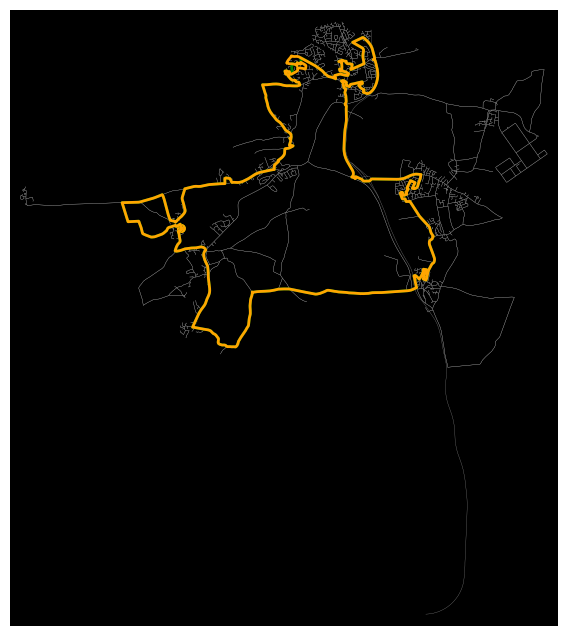

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [560]:
fig, ax = ox.plot_graph(cell_graphs[5], node_size=0, bgcolor ='k', show=False, edge_linewidth=0.2)
ox.plot_graph_routes(cell_graphs[5], [different_42[0], original_42], route_colors=['g','orange'], route_linewidths=2, node_size=0, bgcolor='k', route_alpha=1, ax=ax, orig_dest_size=40)

In [ ]:
fig, ax = ox.plot_graph(cell_graphs[5], node_size=0, bgcolor ='k', show=False, edge_linewidth=0.2)
ox.plot_graph_route(cell_graphs[5], all_routes[5], route_color='r', route_linewidth=1, orig_dest_size=0, route_alpha=0.8, ax=ax)
plt.show()

# Task D

In [ ]:
from prov.model import ProvDocument, Namespace, Literal

# Define the namespaces
EX = Namespace('ex', 'http://example.com/')
PROV = Namespace('prov', 'http://www.w3.org/ns/prov#')

# Create a new provenance document
doc = ProvDocument()

# Define the entities
road_segment = doc.entity(EX['road_segment'])
accident = doc.entity(EX['accident'])
marathon = doc.entity(EX['marathon'])

# Define the activities
accident_report = doc.activity(EX['accident_report'])
marathon_organization = doc.activity(EX['marathon_organization'])

# Define the agents
leeds_city_council = doc.agent(EX['leeds_city_council'])
emergency_services = doc.agent(EX['emergency_services'])
marathon_organizers = doc.agent(EX['marathon_organizers'])

# Define the relationships between the entities, activities, and agents
doc.wasGeneratedBy(accident, accident_report)
doc.wasGeneratedBy(marathon, marathon_organization)

doc.wasAttributedTo(leeds_city_council, accident_report)
doc.wasAttributedTo(emergency_services, accident_report)
doc.wasAttributedTo(marathon_organizers, marathon_organization)

doc.used(accident_report, road_segment)
doc.used(marathon_organization, road_segment)

# visualize the graph
from prov.dot import prov_to_dot
dot = prov_to_dot(doc)
dot.write_png('PROV.png')

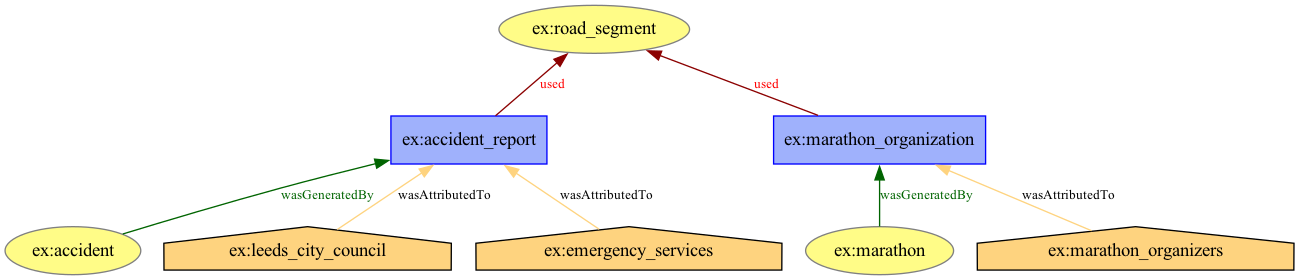

In [ ]:
from IPython.display import Image
Image('PROV.png')